Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



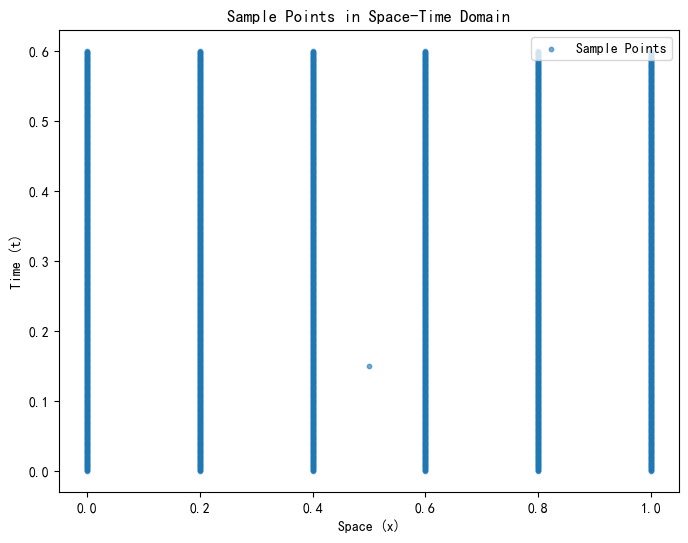

Compiling model...
Building feed-forward neural network...
'build' took 0.039180 s



C:\Users\PS\anaconda3\envs\deepxde\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\PS\AppData\Local\Temp\ipykernel_17436\130705368.py:80: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = tf.layers.dense(X, w_nodenum, activation_func)
C:\Users\PS\AppData\Local\Temp\ipykernel_17436\130705368.py:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = tf.layers.dense(w, w_nodenum, activation_func)
C:\Users\PS\AppData\Local\Temp\ipykernel_17436\130705368.py:83: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y = 0.00001*tf.layers.dense(w, 1, None)


'compile' took 0.481593 s

Training model...

Step      Train loss              Test loss               Test metric
0         [0.00e+00, 1.48e+01]    [0.00e+00, 1.48e+01]    []  
1000      [0.00e+00, 6.96e+00]    [0.00e+00, 6.96e+00]    []  
2000      [0.00e+00, 5.66e+00]    [0.00e+00, 5.66e+00]    []  
3000      [0.00e+00, 3.45e+00]    [0.00e+00, 3.45e+00]    []  
4000      [0.00e+00, 2.83e+00]    [0.00e+00, 2.83e+00]    []  
5000      [0.00e+00, 2.74e+00]    [0.00e+00, 2.74e+00]    []  
6000      [0.00e+00, 2.59e+00]    [0.00e+00, 2.59e+00]    []  
7000      [0.00e+00, 2.51e+00]    [0.00e+00, 2.51e+00]    []  
8000      [0.00e+00, 2.28e+00]    [0.00e+00, 2.28e+00]    []  
9000      [0.00e+00, 2.21e+00]    [0.00e+00, 2.21e+00]    []  
10000     [0.00e+00, 1.99e+00]    [0.00e+00, 1.99e+00]    []  
11000     [0.00e+00, 1.72e+00]    [0.00e+00, 1.72e+00]    []  
12000     [0.00e+00, 2.12e+00]    [0.00e+00, 2.12e+00]    []  
13000     [0.00e+00, 1.69e+00]    [0.00e+00, 1.69e+00]    []  
14

In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
import datetime
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
import re
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from math import sqrt, pi


def generate_labeled_data():
    data_w = loadmat("beam.mat")
    t_data = data_w["t"].flatten()[:, None]  
    x_data = data_w["x"].flatten() 
    y_data = data_w["Y"] 
   
    valid_indices = (t_data >= 0) & (t_data <= 0.6)
    t_data_filtered = t_data[valid_indices]
    y_data_filtered = y_data[valid_indices.flatten(), :] 
    
    num_space_points = 6
    space_indices = np.linspace(0, len(x_data) - 1, num_space_points, dtype=int)  
    x_data_filtered = x_data[space_indices]  
    y_data_filtered_space = y_data_filtered[:, space_indices]  
    X, T = np.meshgrid(x_data_filtered, t_data_filtered.flatten())
    inputs = np.hstack([X.flatten()[:, None], T.flatten()[:, None]])
    outputs = y_data_filtered_space.flatten()[:, None]
    sample_ratio = 1
    num_samples = int(sample_ratio * inputs.shape[0])
    indices = np.random.choice(inputs.shape[0], num_samples, replace=False)
    sampled_inputs = inputs[indices]
    sampled_outputs = outputs[indices]
    return sampled_inputs, sampled_outputs
#————————————————————— ———————————————————————#

xt_data, y_data = generate_labeled_data()
observe_y = dde.icbc.PointSetBC(xt_data, y_data, component=0)  
geom = dde.geometry.Interval(0, 1) 
timedomain = dde.geometry.TimeDomain(0, 0.3) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def FIV(X, Y):   
    DD=0*Y
    return DD

data = dde.data.TimePDE(geomtime,
                        FIV, 
                        [observe_y],  
                        num_domain = 1, 
                        num_boundary = 0)
train_points = data.train_x


plt.figure(figsize=(8, 6))
plt.scatter(train_points[:, 0], train_points[:, 1], s=10, alpha=0.6, label="Sample Points")
plt.xlabel("Space (x)")
plt.ylabel("Time (t)")
plt.title("Sample Points in Space-Time Domain")
plt.legend()
plt.show()

#————————————————————————————————————————————#
net = dde.maps.FNN([2] + [1], None, "Glorot uniform")   
w_nodenum = 256
w_layer = 4
activation_func = "tanh"
def modify_output(X, Y):  
    w = tf.layers.dense(X, w_nodenum, activation_func)
    for i in range(w_layer):
        w = tf.layers.dense(w, w_nodenum, activation_func)
    y = 0.00001*tf.layers.dense(w, 1, None)
    return y
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
#————————————————————————————————————————————#


epochs=10000

model.compile("adam",
              lr=1e-3,loss=["MAE","MAE"], loss_weights=[0,1e6])
loss_history, train_state = model.train(iterations=4*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)
model.compile("adam",
              lr=1e-4,loss=["MAE","MAE"],
              loss_weights=[0,1e6])
loss_history, train_state = model.train(iterations=4*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)
model.compile("adam",
              lr=1e-5,loss=["MAE","MAE"],
              loss_weights=[0,1e6])
loss_history, train_state = model.train(iterations=6*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)
model.compile("adam",
              lr=1e-5,loss=["MAE","MAE"],
              loss_weights=[0,1e6])
loss_history, train_state = model.train(iterations=10*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True)


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


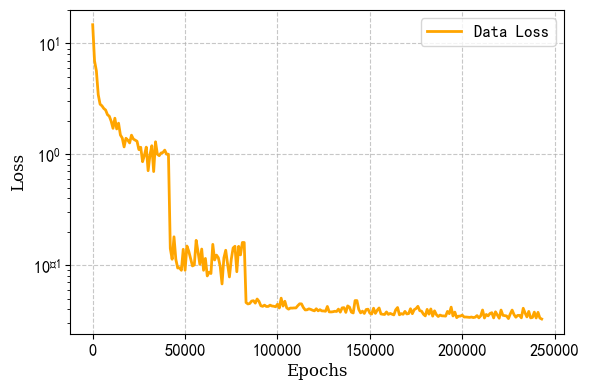

In [2]:
# 假设 train_loss 包含每个 epoch 的 7 个损失值
train_loss = loss_history.loss_train

# 提取每个 epoch 的第一个损失值（假设是物理损失）和第二个损失值（假设是数据损失）
physics_losses = [loss[0] for loss in train_loss]
data_losses = [loss[1] for loss in train_loss]


epochs = np.arange(len(train_loss)) * 1000  # 假设每个点是 1000 个 epoch

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}


    # 绘制损失函数
plt.figure(figsize=(6, 4))
# 使用不同的线型和颜色
plt.plot(epochs, data_losses, label='Data Loss', color='orange', linestyle='-', linewidth=2)  # 虚线
#plt.plot(epochs, physics_losses, label='Physics Loss', color='blue', linestyle='-.')  # 点划线
#plt.plot(epochs, total_losses, label='Total Loss', color='red', linestyle='-')  # 点线
plt.yscale('log')  # 将 Y 轴设置为对数坐标
plt.title('', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Loss', fontdict=font)

plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.savefig("损失函数.png", dpi=300)
plt.show()

C:\Users\PS\AppData\Local\Temp\ipykernel_17436\622555312.py:33: RuntimeWarning: divide by zero encountered in divide
  R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)


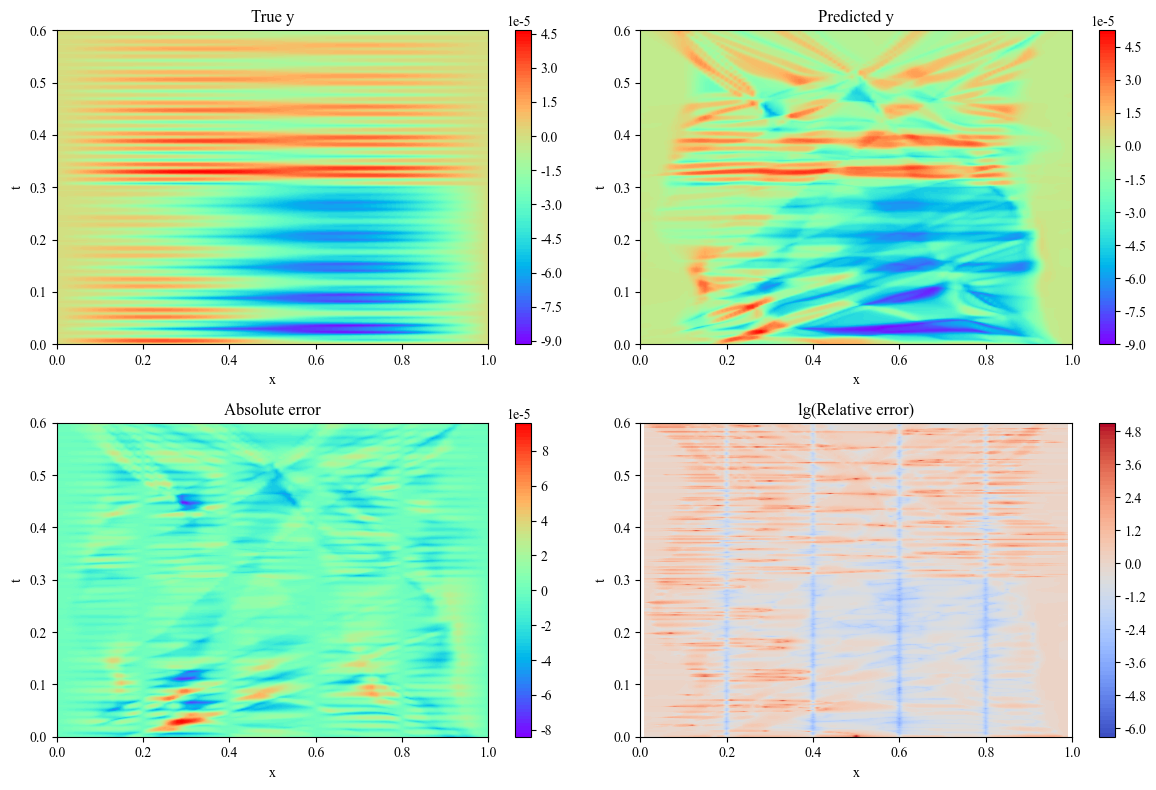

In [3]:
def generate_labeled_data2():
    data_w = loadmat("beam.mat")

    t_data = data_w["t"].flatten()[:, None]  
    x_data = data_w["x"].flatten()  
    y_data = data_w["Y"]
    valid_indices = (t_data >= 0) & (t_data <= 0.6)
    t_data_filtered = t_data[valid_indices]
    y_data_filtered = y_data[valid_indices.flatten(), :]  

    X, T = np.meshgrid(x_data, t_data_filtered.flatten())

    inputs = np.hstack([X.flatten()[:, None], T.flatten()[:, None]])
    outputs = y_data_filtered.flatten()[:, None]

    return inputs, outputs

xt2_data, y2_data = generate_labeled_data2()

predictions = model.predict(xt2_data)
Y_PRE=predictions [:,0:1]



X = xt2_data[:, 0].reshape(-1, 101)  
T = xt2_data[:, 1].reshape(-1, 101) 

y_true_reshaped= y2_data.reshape(-1, 101)
y_pre_reshaped = Y_PRE.reshape(-1, 101)

y_error = y_pre_reshaped - y_true_reshaped

R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10  


plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.contourf(X, T, y_true_reshaped, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('True y')

plt.subplot(2, 2, 2)
plt.contourf(X, T, y_pre_reshaped, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted y')

plt.subplot(2, 2, 3)
plt.contourf(X, T, y_error, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute error')

log_R_y_error = np.log10(R_y_error) 
plt.subplot(2, 2, 4)
plt.contourf(X, T, log_R_y_error, levels=100, cmap='coolwarm')
plt.colorbar(label='')
plt.xlabel('x')
plt.ylabel('t')
plt.title('lg(Relative error)')
plt.tight_layout()
plt.savefig("数据驱动 响应预测.png", dpi=300)
plt.show()


C:\Users\PS\AppData\Local\Temp\ipykernel_17436\2906835537.py:18: RuntimeWarning: divide by zero encountered in divide
  relative_error_1_4 = np.abs(y_true_1_4 - y_pred_1_4) / np.abs(y_true_1_4)
C:\Users\PS\AppData\Local\Temp\ipykernel_17436\2906835537.py:19: RuntimeWarning: divide by zero encountered in divide
  relative_error_1_2 = np.abs(y_true_1_2 - y_pred_1_2) / np.abs(y_true_1_2)
C:\Users\PS\AppData\Local\Temp\ipykernel_17436\2906835537.py:20: RuntimeWarning: divide by zero encountered in divide
  relative_error_3_4 = np.abs(y_true_3_4 - y_pred_3_4) / np.abs(y_true_3_4)


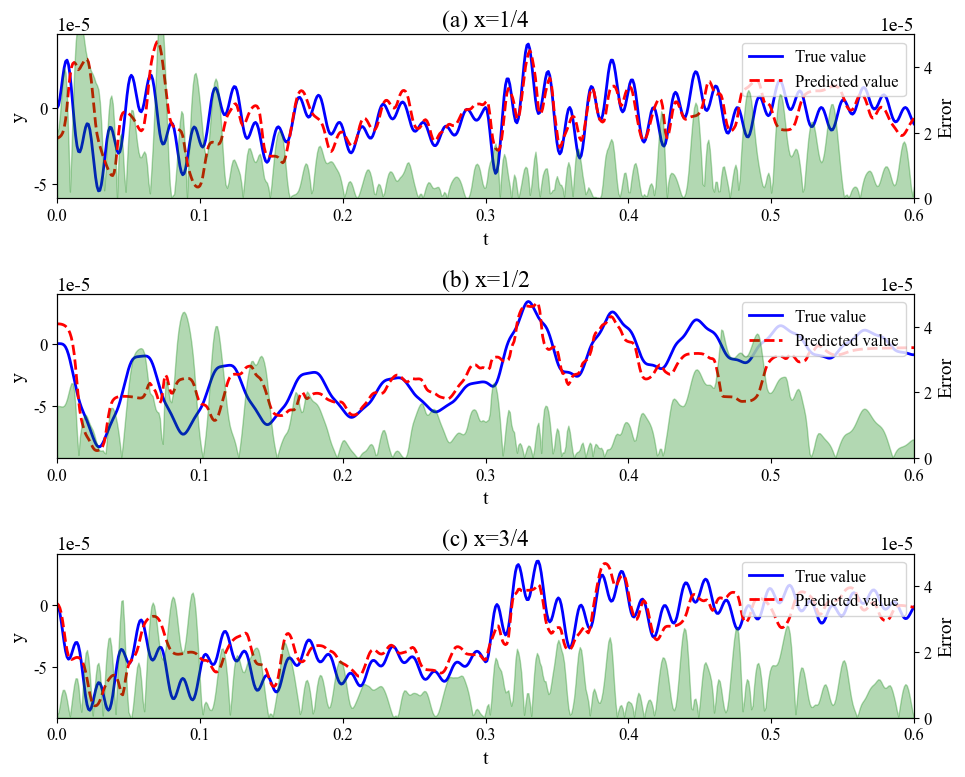

In [4]:
x_indices = [25, 50, 75] 

t_data = xt2_data[:, 1].reshape(-1, 101) 

y_true_reshaped= y2_data.reshape(-1, 101)

y_pre_reshaped = Y_PRE.reshape(-1, 101)

y_true_1_4 = y_true_reshaped[:, 25:26]
y_true_1_2 = y_true_reshaped[:, 50:51]
y_true_3_4 = y_true_reshaped[:, 75:76]


y_pred_1_4 = y_pre_reshaped[:, 25:26]
y_pred_1_2 = y_pre_reshaped[:, 50:51]
y_pred_3_4 = y_pre_reshaped[:, 75:76]

relative_error_1_4 = np.abs(y_true_1_4 - y_pred_1_4) / np.abs(y_true_1_4)
relative_error_1_2 = np.abs(y_true_1_2 - y_pred_1_2) / np.abs(y_true_1_2)
relative_error_3_4 = np.abs(y_true_3_4 - y_pred_3_4) / np.abs(y_true_3_4)
Error_1_4 = np.abs(y_true_1_4 - y_pred_1_4) 
Error_1_2 = np.abs(y_true_1_2 - y_pred_1_2)
Error_3_4 = np.abs(y_true_3_4 - y_pred_3_4)



plt.figure(figsize=(10, 8))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14 


epsilon = 1e-10


plt.subplot(3, 1, 1)
ax1 = plt.gca()  
ax2 = ax1.twinx()  

ax1.plot(t_data[:, 0], y_true_1_4, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_1_4, label='Predicted value', color='red', linestyle='--', linewidth=2)

ax2.fill_between(t_data[:, 0], 0, Error_1_4.flatten(), color='green', alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 0.6)
ax2.set_ylim(0, 5e-5)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(a) x=1/4')
ax1.legend(loc='upper right', fontsize=12)

# 绘制1/2位置的对比
plt.subplot(3, 1, 2)
ax1 = plt.gca() 
ax2 = ax1.twinx()  



ax1.plot(t_data[:, 0], y_true_1_2, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_1_2, label='Predicted value', color='red', linestyle='--', linewidth=2)


log_relative_error_1_2 = np.log(np.abs(relative_error_1_2.flatten()) + epsilon)

ax2.fill_between(t_data[:, 0], 0, Error_1_2.flatten(), color='green', alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 0.6)
ax2.set_ylim(0, 5e-5)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(b) x=1/2')
ax1.legend(loc='upper right', fontsize=12)


plt.subplot(3, 1, 3)
ax1 = plt.gca()  
ax2 = ax1.twinx() 

ax1.plot(t_data[:, 0], y_true_3_4, label='True value', color='blue', linestyle='-', linewidth=2)
ax1.plot(t_data[:, 0], y_pred_3_4, label='Predicted value', color='red', linestyle='--', linewidth=2)


log_relative_error_3_4 = np.log(np.abs(relative_error_3_4.flatten()) + epsilon)

ax2.fill_between(t_data[:, 0], 0, Error_3_4.flatten(), color='green', alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('y')
ax2.set_ylabel('Error')
ax1.set_xlim(0, 0.6)
ax2.set_ylim(0, 5e-5)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax1.set_title('(c) x=3/4')
ax1.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig("响应对比.png", dpi=300)
plt.show()



Pearson correlation coefficient: 0.8629661256383114
决定系数 (R²): 0.744710533999198


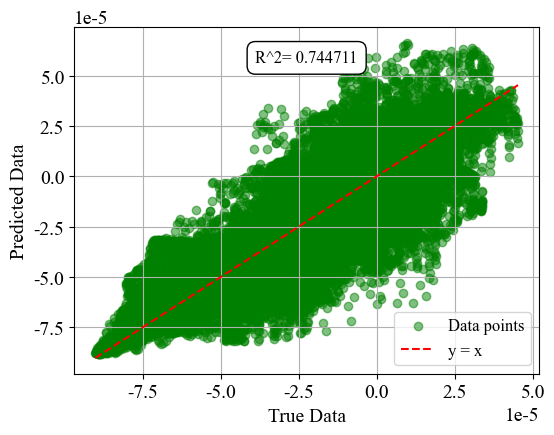

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  

plt.figure(figsize=(6, 4.5))

plt.scatter(y2_data, Y_PRE, color="green", alpha=0.5, label="Data points")
y2_data = y2_data.flatten()
Y_PRE = Y_PRE.flatten()

correlation, _ = pearsonr(y2_data, Y_PRE)
print(f"Pearson correlation coefficient: {correlation}")
r_squared = correlation ** 2
print(f"决定系数 (R²): {r_squared}")

plt.text(0.5, 0.9, f"R^2= {r_squared:.6f}", fontsize=12, ha='center', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


plt.plot([min(y2_data), max(y2_data)], [min(y2_data), max(y2_data)], color="red", linestyle="--", label="y = x")

plt.xlabel("True Data")
plt.ylabel("Predicted Data")
plt.title("")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
plt.legend(loc='lower right', fontsize=12)  
plt.grid()

plt.savefig("预测精度.png", dpi=300)